In [1]:
#ライブラリの読み込み

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
from numpy import nan
import seaborn as sns

#データの読み込み
df = pd.read_csv('train_taitanic.csv')

In [2]:
#欠損値処理

#敬称による分類、繰り返し文{'Miss.':0,'Mrs.':1,'Master':2,'Mr':3}
#Msは1人なのでMrsに追加
#3には数人Dr.などいるがMr.として考える

list_n = []
for name in df.loc[:,['Name']].values.reshape(-1):
    if 'Miss.' in name:
        list_n.append(0)
    elif 'Mrs.' in name or 'Ms.' in name:
        list_n.append(1)
    elif 'Master.' in name:
        list_n.append(2)
    else:
        list_n.append(3)

In [3]:
#dfにHonorificカラムを追加
df['Honorific'] = np.array(list_n)

In [4]:
#敬称ごとの年齢の平均値、中央値を出力

age_mean = df.groupby('Honorific').Age.mean()
age_median = df.groupby('Honorific').Age.median()
print(age_mean)
print(age_median)

Honorific
0    21.773973
1    35.825688
2     4.574167
3    32.994090
Name: Age, dtype: float64
Honorific
0    21.0
1    35.0
2     3.5
3    30.0
Name: Age, dtype: float64


In [5]:
#Ageの欠損値を敬称ごとの平均値で補完

#Ageが欠損しているindexを取り出しのlistを作成
age_nan = df.Age.isnull()
list_nan = age_nan.values
list_t = []
for i in range(len(list_nan)):
    if list_nan[i] == True:
        list_t.append(i)
        
#list_tに対して敬称ごとの年齢の中央値が対応するlistの作成
list_m = []
for i in list_t:
    list_m.append(age_mean[df.Honorific[i]])
    
#df_ageカラムを作成し、dfに追加
df_age = df.loc[:,['Age']]
for j,k in zip(list_t, list_m):    
    df_age.Age[j] = k

df['Age_mod'] = df_age

In [6]:
#Sexをダミー変数化
df['Female'] = df['Sex'].map({'male':0,'female':1})

#Pclassをダミー変数化
#Embarkedをダミー変数化
pclass = pd.get_dummies(df['Pclass'],prefix ='Class')
embarked = pd.get_dummies(df['Embarked'], prefix='Embarked')

#df,pclass,embarkedを結合
df = pd.concat([df, pclass, embarked], axis=1)

In [7]:
#Embarkedに欠損値を持つサンプルを削除
df = df.dropna(subset=['Embarked'])

#不必要なPassengerId,Name,Age,Ticket,Cabin,Embarkedを説明変数から削除
#多重共線性を防ぐためにClass_3,Embarked_Qを削除
df = df.drop(['PassengerId','Pclass','Name','Sex','Embarked',
              'Age','Ticket','Cabin','Class_3','Embarked_Q'], axis=1)

In [8]:
#columnsを出力
df.columns

Index(['Survived', 'SibSp', 'Parch', 'Fare', 'Honorific', 'Age_mod', 'Female',
       'Class_1', 'Class_2', 'Embarked_C', 'Embarked_S'],
      dtype='object')

In [9]:
#欠損値処理　終了　     ↑↑↑
#モデル学習、実行　開始　↓↓↓

In [103]:
#説明変数と目的変数を指定
#全て使ってみる
X_0 = df.drop(['Survived'], axis=1).values
y_0 = df.loc[:,['Survived']].values.reshape(-1)

#データの分割
from sklearn.model_selection import train_test_split
X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(X_0, y_0, test_size=0.3, 
                                                                random_state=0)

In [104]:
#決定木による学習
from sklearn.tree import DecisionTreeClassifier
tree_0 = DecisionTreeClassifier(random_state=0,max_depth=3)
tree_0.fit(X_0_train, y_0_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [105]:
print(tree_0.score(X_0_train, y_0_train))
print(tree_0.score(X_0_test, y_0_test))

0.83922829582
0.782771535581


In [106]:
# ランダムフォレストによる学習
from sklearn.ensemble import RandomForestClassifier
rfc_0 = RandomForestClassifier(random_state=0, n_estimators=5)
rfc_0.fit(X_0_train, y_0_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [107]:
#決定係数を出力
print(rfc_0.score(X_0_train, y_0_train))
print(rfc_0.score(X_0_test, y_0_test))

0.96463022508
0.797752808989


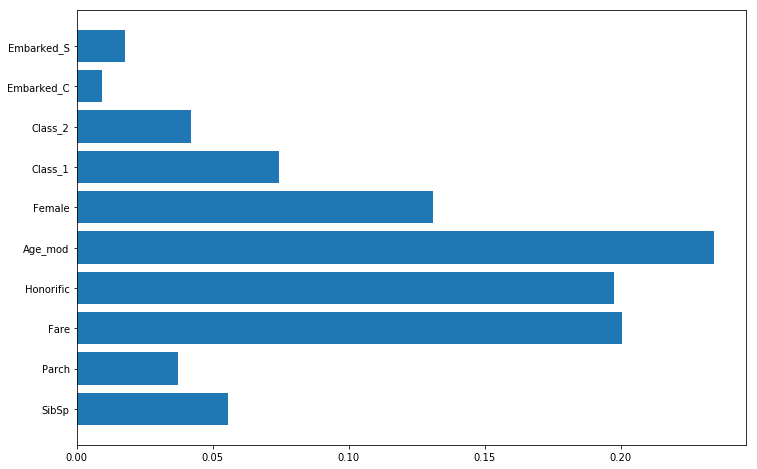

In [108]:
# 特徴量の重要度をグラフに出力
n_features = len(df.columns)-1
plt.figure(figsize=(12, 8))
plt.barh(range(n_features), rfc_0.feature_importances_ , align='center')
plt.yticks(np.arange(n_features),['SibSp', 'Parch', 'Fare', 'Honorific', 'Age_mod', 
                                  'Female','Class_1', 'Class_2', 'Embarked_C', 'Embarked_S'] )
plt.show()

In [109]:
# 勾配ブースティング木で学習させる
from sklearn.ensemble import GradientBoostingClassifier
gbct_0 = GradientBoostingClassifier(n_estimators=5,random_state=0, max_depth=3, learning_rate=0.1)
gbct_0.fit(X_0_train, y_0_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
              random_state=0, subsample=1.0, verbose=0, warm_start=False)

In [110]:
#決定係数を出力
print(gbct_0.score(X_0_train, y_0_train))
print(gbct_0.score(X_0_test, y_0_test))

0.83922829582
0.801498127341


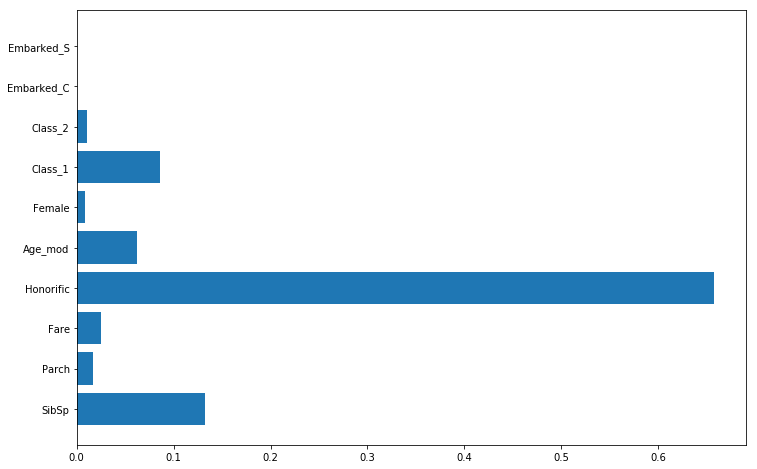

In [111]:
# 特徴量の重要度をグラフに出力
n_features = len(df.columns)-1
plt.figure(figsize=(12, 8))
plt.barh(range(n_features), gbct_0.feature_importances_ , align='center')
plt.yticks(np.arange(n_features),['SibSp', 'Parch', 'Fare', 'Honorific', 'Age_mod', 
                                  'Female','Class_1', 'Class_2', 'Embarked_C', 'Embarked_S'] )
plt.show()

In [112]:
#↑↑↑['Class_1','Female','Age_mod','Honorific','Fare','Sibsp']の重要度が高い

#↓↓↓これらの特徴量を用いてもう一度モデル学習、実行

In [117]:
#説明変数と目的変数を指定

X_1 = df.loc[:,['Class_1','Female','Age_mod',
                'Honorific','Fare','SibSp']].values
y_1 = df.loc[:,['Survived']].values.reshape(-1)
             
#データの分割
from sklearn.model_selection import train_test_split
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.3, 
                                                                random_state=1)

In [186]:
#ロジスティック回帰の実行
#カーネルSVCの実行
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

lr_1 = LogisticRegression(C=1.0)
lr_1.fit(X_1_train, y_1_train)
svc_1 = SVC(kernel='rbf', gamma=0.05, C=100)
svc_1.fit(X_1_train, y_1_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [187]:
#決定係数を出力
print(lr_1.score(X_1_train, y_1_train))
print(lr_1.score(X_1_test, y_1_test))
print(svc_1.score(X_1_train, y_1_train))
print(svc_1.score(X_1_test, y_1_test))

0.773311897106
0.812734082397
0.815112540193
0.820224719101


In [127]:
# ランダムフォレストによる学習
from sklearn.ensemble import RandomForestClassifier
rfc_1 = RandomForestClassifier(random_state=1, n_estimators=10)
rfc_1.fit(X_1_train, y_1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [128]:
#決定係数を出力
print(rfc_1.score(X_1_train, y_1_train))
print(rfc_1.score(X_1_test, y_1_test))

0.969453376206
0.820224719101


In [173]:
# 勾配ブースティング木で学習させる
from sklearn.ensemble import GradientBoostingClassifier
gbct_1 = GradientBoostingClassifier(n_estimators=10,random_state=1, max_depth=4, learning_rate=0.1)
gbct_1.fit(X_1_train, y_1_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False)

In [174]:
#決定係数を出力
print(gbct_1.score(X_1_train, y_1_train))
print(gbct_1.score(X_1_test, y_1_test))

0.842443729904
0.85393258427
